# Starbucks Sentiment Analysis 2018
An analysis of online comments at http://reddit.com. 




### Import Python Libraries

In [30]:

import numpy as np
import pandas as pd
from datetime import datetime

#Graphing Libraries
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns



### Connect to Google Cloud Platform

In [6]:
from google.cloud import bigquery
from google.oauth2 import service_account

key_location =  '/users/steve/Documents/xxxxxxxx/xxxxx/xxxxxx/reddit-energy-xxxxxxxxxxx.json'
credentials = service_account.Credentials.from_service_account_file(key_location)

project_id = 'reddit-energy'
client = bigquery.Client(credentials= credentials,project=project_id)

### Function to handle positive, negative, or neutral comments

In [134]:
#Natural Language Processing Libraries
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

def polarity_label(polarity_value):
    try:
        if polarity_value >= 0.1:
            return 'positive'
        elif polarity_value <= -0.1:
            return 'negative'
        else:
            return 'neutral'
    except:
        pass

    

### Pulls discussion threads that have a mention of Starbucks

In [31]:
sql = """with base_query as
(select *
  FROM
  (select created_utc,parent_id,score,body FROM `fh-bigquery.reddit_comments.2018_03`
  union all
  select created_utc,parent_id,score,body FROM `fh-bigquery.reddit_comments.2018_04`
  union all
  select created_utc,parent_id,score,body FROM `fh-bigquery.reddit_comments.2018_05`
  union all
  select created_utc,parent_id,score,body FROM `fh-bigquery.reddit_comments.2018_06`
  )
  #limit 10000
)
,starbucks_mentions as
(select parent_id from base_query
WHERE
   score > 1 AND (body LIKE '%Starbucks%'
       OR body LIKE '%starbucks%'
       OR body LIKE '%starbuck%'))
,t1 as
(Select base_query.created_utc,base_query.body,starbucks_mentions.parent_id starbucks_parent from base_query
left join starbucks_mentions on base_query.parent_id = starbucks_mentions.parent_id
)
Select created_utc,body from t1
where (t1.starbucks_parent is not null
       OR (t1.body LIKE '%Starbucks%'
       OR t1.body LIKE '%starbucks%'
       OR t1.body LIKE '%starbuck%')) 

"""

query_job = client.query(sql)
df = query_job.result().to_dataframe()  # Creates at DataFrame
df['created_utc'] = df['created_utc'].apply(lambda dt:datetime.utcfromtimestamp(dt))
df['sentiment'] = df['body'].apply(lambda comment: polarity_label(TextBlob(comment).sentiment.polarity))
df['positive'] = np.where(df['sentiment']=='positive', 1, 0)
df['neutral'] = np.where(df['sentiment']=='neutral', 1, 0)
df['negative'] = np.where(df['sentiment']=='negative', 1, 0)
df.drop(['body','sentiment'],axis=1,inplace=True)
df.set_index('created_utc',inplace=True,drop=True)
df.resample('D').sum().to_csv('Starbucks_Sentiment.csv') #Export to file

In [84]:
df_all = pd.read_csv('Starbucks_Sentiment.csv')
df_all['created_date']=pd.to_datetime(df_all['created_utc'], format='%Y-%m-%d',errors='raise')
#df2['conv_date']=pd.to_datetime(df2['created_utc'],errors='raise')
df_all.set_index('created_date',inplace=True,drop=True)
df_all.drop(['created_utc'],axis=1,inplace=True)

## Plot Sentiment for all discussion threads

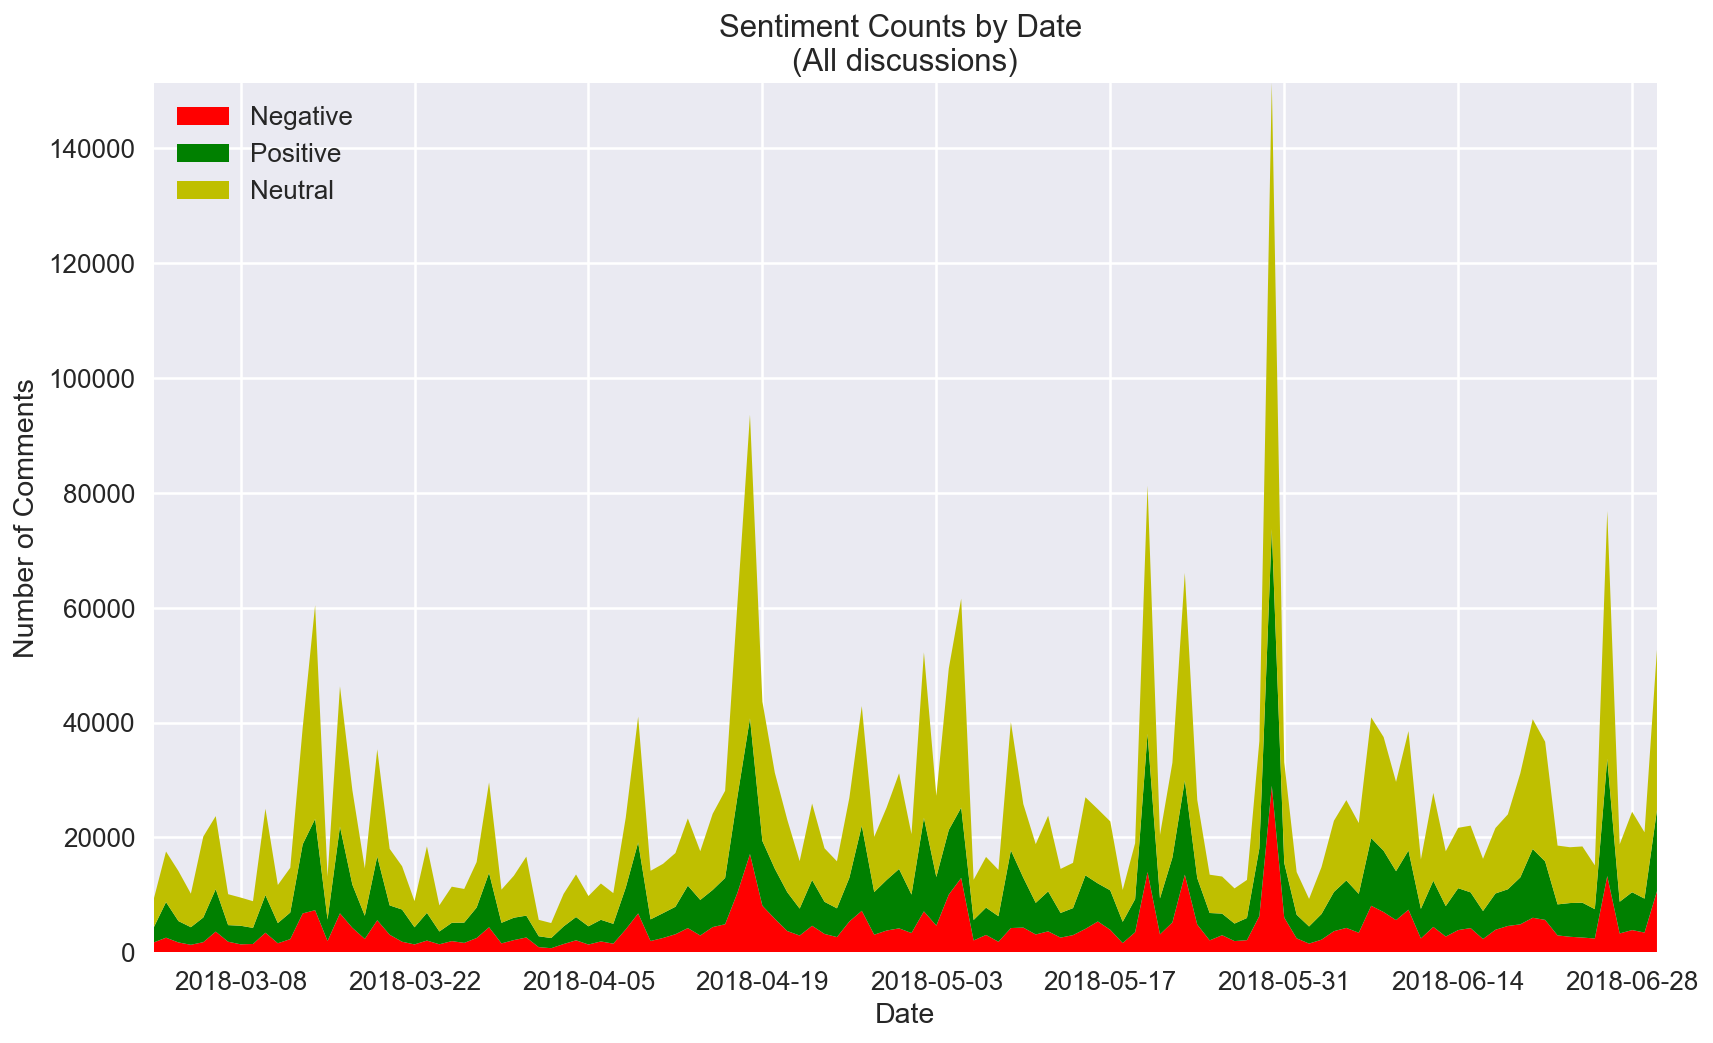

In [85]:
# All Discussion Threads
plt.figure(figsize=(12,8)) 
plt.stackplot(df_all.index,  df_all["negative"],  df_all["positive"],  df_all["neutral"], labels=['Negative','Positive','Neutral'],colors=['r','g','y'])
plt.legend(loc='upper left')

plt.xlabel('Date')
plt.ylabel('Number of Comments')
plt.margins(0,0)
plt.title('Sentiment Counts by Date \n(All discussions)')
plt.show();

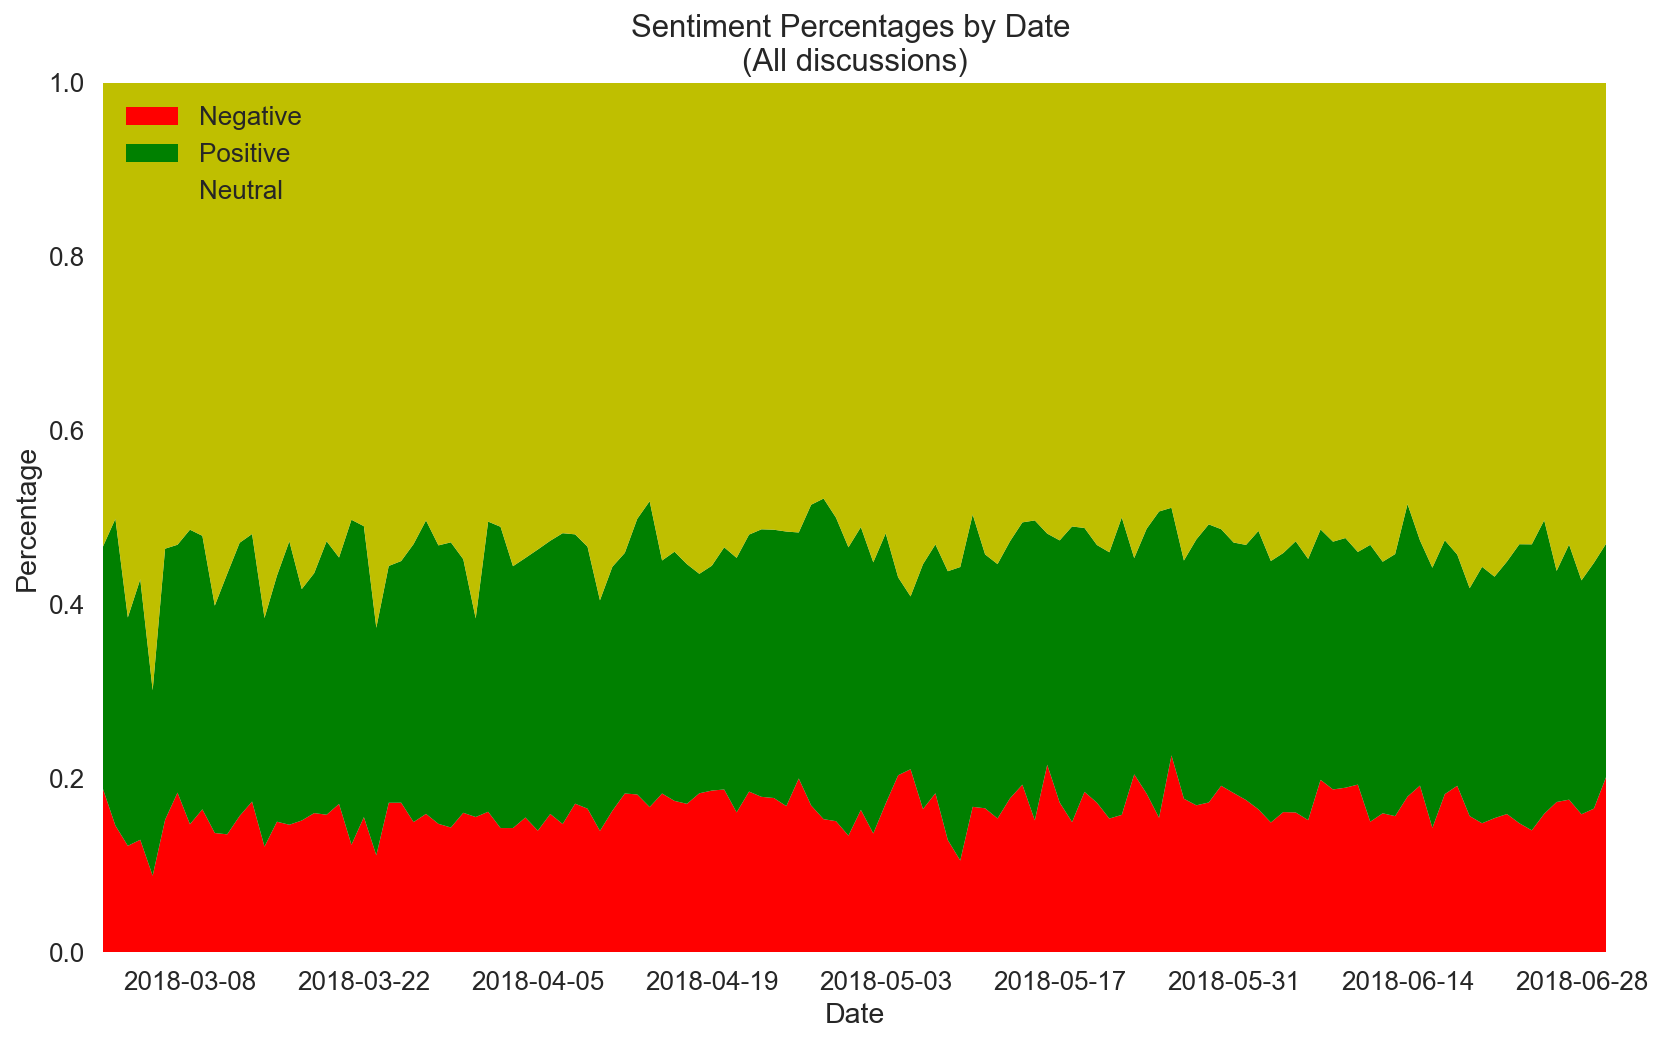

In [80]:
# Make the plot
data_perc = df_all.divide(df_all.sum(axis=1), axis=0)
plt.figure(figsize=(12,8)) 
plt.stackplot(df_all.index,  data_perc["negative"],  data_perc["positive"],  data_perc["neutral"], labels=['Negative','Positive','Neutral'],colors=['r','g','y'])
plt.legend(loc='upper left')

plt.xlabel('Date')
plt.ylabel('Percentage')
plt.margins(0,0)
plt.title('Sentiment Percentages by Date \n(All discussions)')
plt.show();

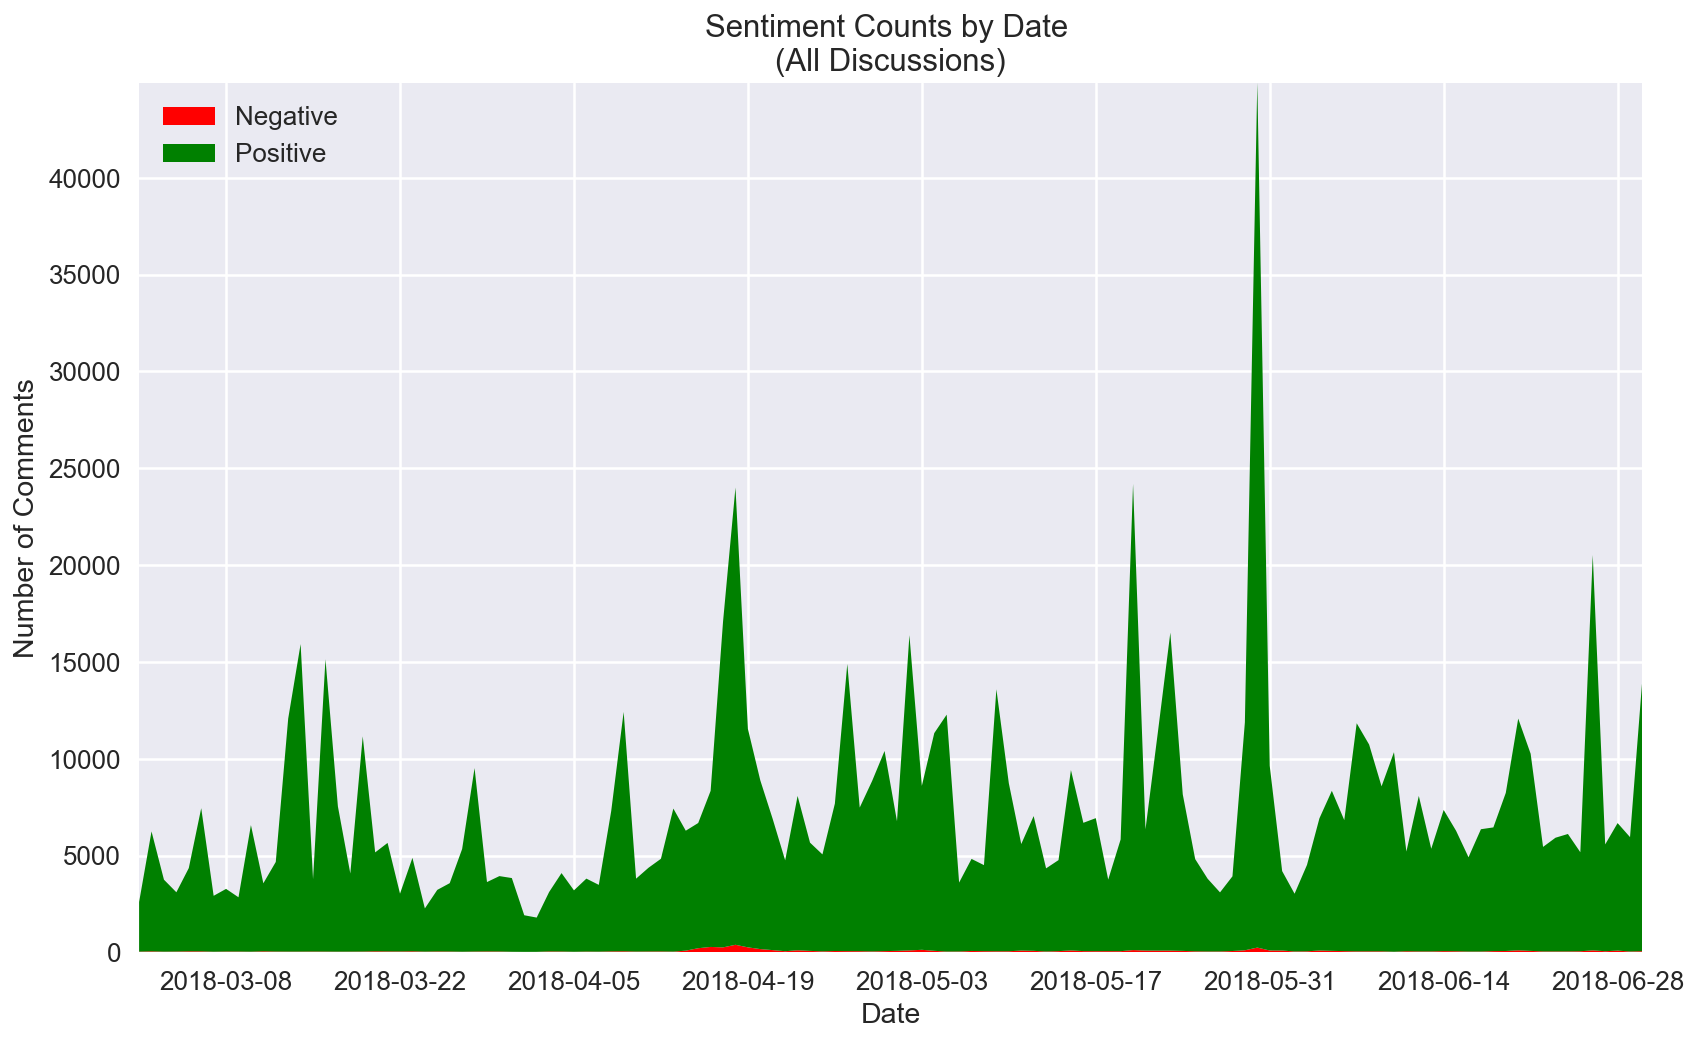

In [86]:
# Make the plot
plt.figure(figsize=(12,8)) 
plt.stackplot(df_all.index,  df_star_agg["negative"],  df_all["positive"],  labels=['Negative','Positive'],colors=['r','g'])
plt.legend(loc='upper left')

plt.xlabel('Date')
plt.ylabel('Number of Comments')
plt.margins(0,0)
plt.title('Sentiment Counts by Date \n(All Discussions)')
plt.show();

### Pull only individual comments that mention Starbucks

In [ ]:
sql_starbucks = """with base_query as
(select *
  FROM
  (select created_utc,parent_id,score,body FROM `fh-bigquery.reddit_comments.2018_03`
  union all
  select created_utc,parent_id,score,body FROM `fh-bigquery.reddit_comments.2018_04`
  union all
  select created_utc,parent_id,score,body FROM `fh-bigquery.reddit_comments.2018_05`
  union all
  select created_utc,parent_id,score,body FROM `fh-bigquery.reddit_comments.2018_06`
  )
  #limit 1000
)
Select created_utc,body,score from base_query
where (base_query.score > 1 AND (base_query.body LIKE '%Starbucks%'
                                OR base_query.body LIKE '%starbucks%'
                                OR base_query.body LIKE '%starbuck%')
      )"""

query_job = client.query(sql_starbucks)
df_starbucks = query_job.result().to_dataframe()  # Creates at DataFrame
df_starbucks['created_utc'] = df_starbucks['created_utc'].apply(lambda dt:datetime.utcfromtimestamp(dt))
df_starbucks['sentiment'] = df_starbucks['body'].apply(lambda comment: polarity_label(TextBlob(comment).sentiment.polarity))
df_starbucks['positive'] = np.where(df_starbucks['sentiment']=='positive', 1, 0)
df_starbucks['neutral'] = np.where(df_starbucks['sentiment']=='neutral', 1, 0)
df_starbucks['negative'] = np.where(df_starbucks['sentiment']=='negative', 1, 0)
df_starbucks.drop(['body','sentiment'],axis=1,inplace=True)
df_starbucks.set_index('created_utc',inplace=True,drop=True)
df_starbucks.resample('D').sum().to_csv('Starbucks_Mentions.csv') #Export to file

In [59]:
df_star_agg = pd.read_csv('Starbucks_Mentions.csv')
df_star_agg['created_date']=pd.to_datetime(df_star_agg['created_utc'], format='%Y-%m-%d',errors='raise')
df_star_agg.set_index('created_date',inplace=True,drop=True)
df_star_agg.drop(['created_utc','score'],axis=1,inplace=True)


### Plot Starbucks comments only

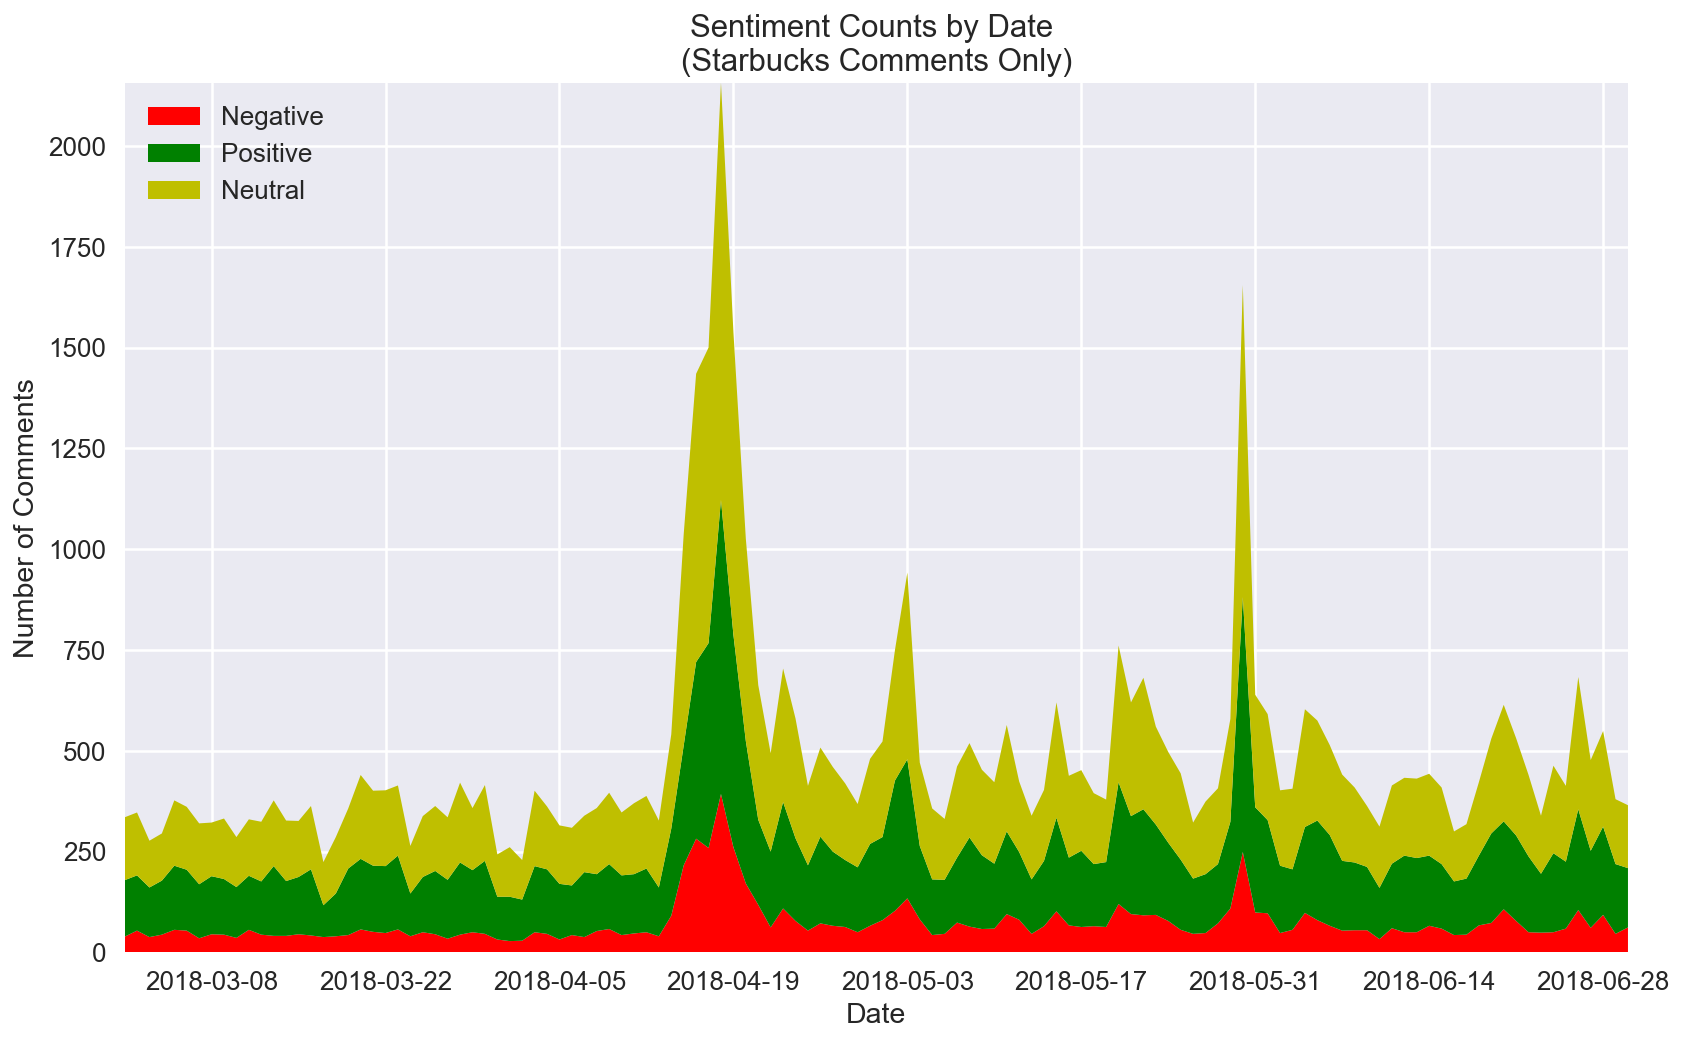

In [77]:

plt.figure(figsize=(12,8)) 
plt.stackplot(df_star_agg.index,  df_star_agg["negative"],  df_star_agg["positive"],  df_star_agg["neutral"], labels=['Negative','Positive','Neutral'],colors=['r','g','y'])
plt.legend(loc='upper left')

plt.xlabel('Date')
plt.ylabel('Number of Comments')
plt.margins(0,0)
plt.title('Sentiment Counts by Date \n(Starbucks Comments Only)')
plt.show();

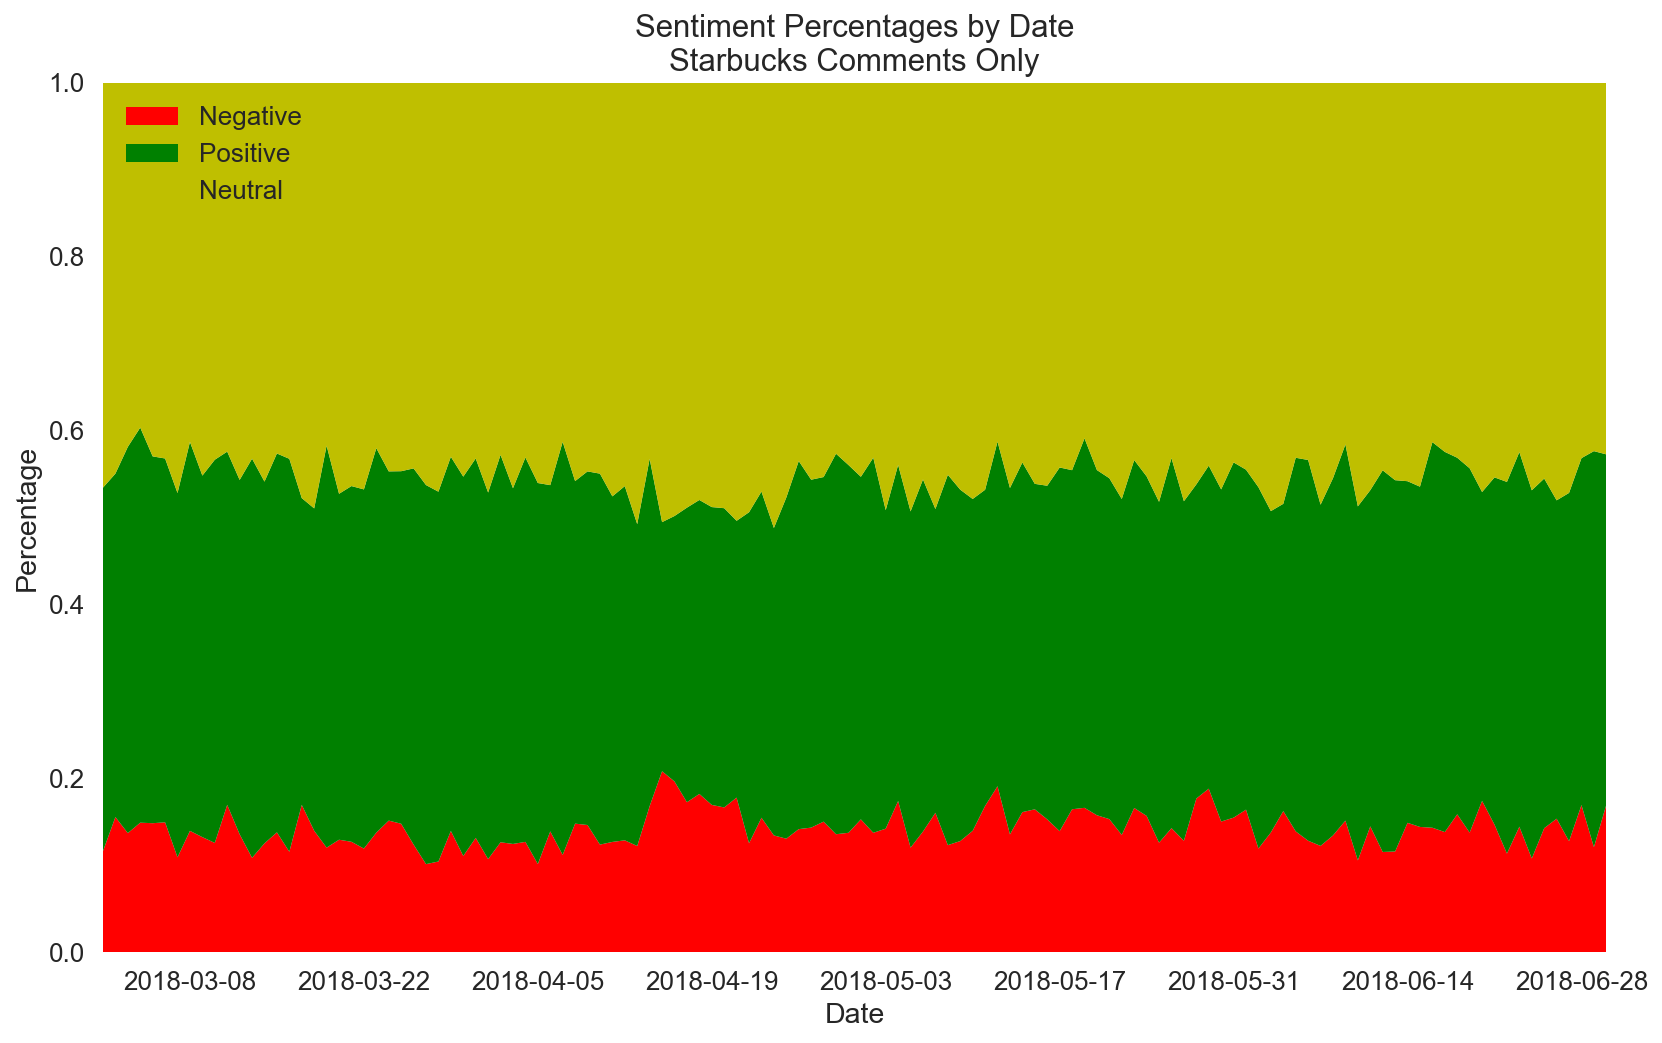

In [78]:
# Make the plot
data_perc = df_star_agg.divide(df_star_agg.sum(axis=1), axis=0)
plt.figure(figsize=(12,8)) 
plt.stackplot(df_star_agg.index,  data_perc["negative"],  data_perc["positive"],  data_perc["neutral"], labels=['Negative','Positive','Neutral'],colors=['r','g','y'])
plt.legend(loc='upper left')

plt.xlabel('Date')
plt.ylabel('Percentage')
plt.margins(0,0)
plt.title('Sentiment Percentages by Date\nStarbucks Comments Only')
plt.show();

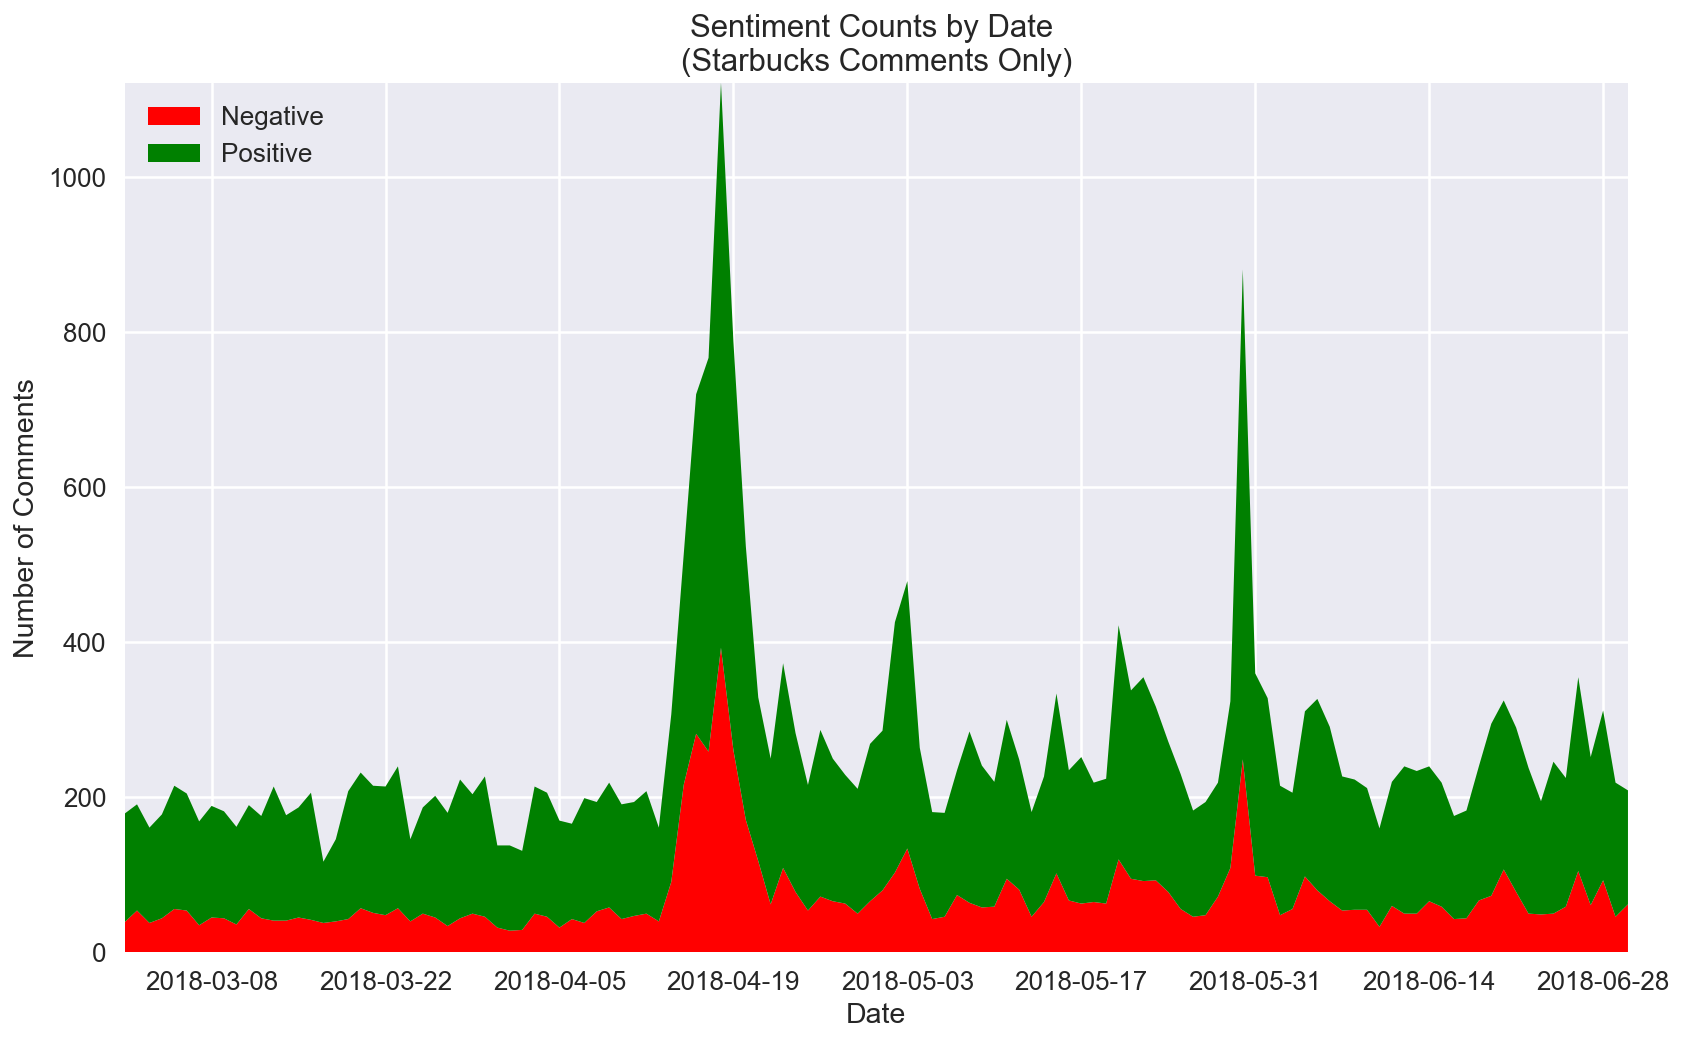

In [87]:
# Make the plot
plt.figure(figsize=(12,8)) 
plt.stackplot(df_star_agg.index,  df_star_agg["negative"],  df_star_agg["positive"],  labels=['Negative','Positive','Neutral'],colors=['r','g','y'])
plt.legend(loc='upper left')

plt.xlabel('Date')
plt.ylabel('Number of Comments')
plt.margins(0,0)
plt.title('Sentiment Counts by Date \n(Starbucks Comments Only)')
plt.show();

# Observations


There was a spike of negative sentiment on the day of the incident (April 12,2018) that dropped lower but not quite to the pre-incident levels. 

A second spike of negative sentiment occurred on May 29,2018 when Starbucks closed its stores for sensitivity training.

There were always more favorable comments than negative comments.


# Conclusion

    


The incident that occurred during April 2018 had an observable impact on people's feelings about the company based on discussions on reddit.com
